# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

GITHUB LINK: https://github.com/Archelon225/ECE188_S22

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [5]:
# Code to make this work in Google Colab:

from google.colab import drive
drive.mount('/content/gdrive')

import sys

sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [78]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

import pdb # for debugging
import numpy as np


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [74]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [29]:
image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/powell_cat.png')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

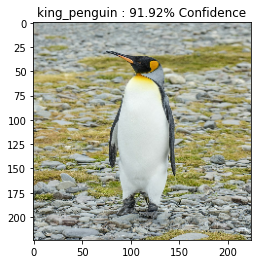

In [38]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [31]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

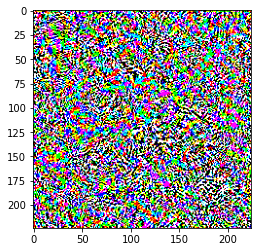

In [32]:
# Get the input label of the image.
my_image_index = 285
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [33]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

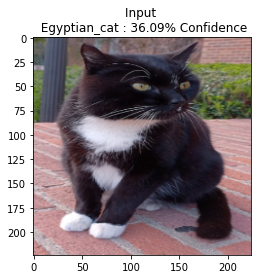

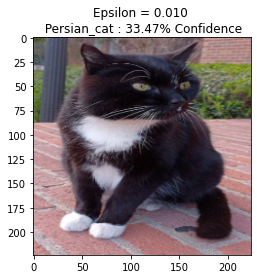

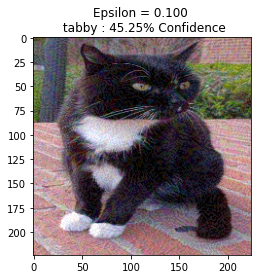

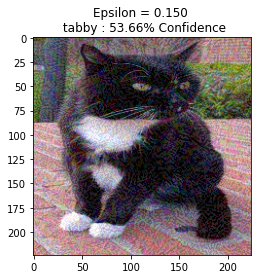

In [34]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [83]:
# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.15, step = 0.001)

actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# King penguin needs epsilon = 0.116 to change into a different class


Epsilon is  0.116


In [84]:
# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.40, step = 0.001)

actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass
# Agaric needs epsilon of 0.377

Epsilon is  0.377


In [87]:
# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.15, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

Epsilon is  0.001


In [88]:
# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.15, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

Epsilon is  0.002


In [89]:
# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# Lionfish changes at epsilon = 0.279

Epsilon is  0.279


In [90]:
# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

  # Otter changes at epsilon = 0.002

Epsilon is  0.002


In [91]:
# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# Tank changes at epsilon = 0.017

Epsilon is  0.017


In [92]:
# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# Pomegranate changes at epsilon = 0.014

Epsilon is  0.014


In [93]:
# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# Sea urchin changes at epsilon = 0.628

Epsilon is  0.628


In [94]:
# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 0.70, step = 0.001)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon is ", eps)
    break

    pass

  pass

# Mantis changes at epsilon = 0.002

Epsilon is  0.002


Summary table:

| Image class      | Minimum epsilon needed |
| ----------- | ----------- |
| King penguin      | 0.116       |
|  Agaric  | 0.377        |
|    Warthog      |   0.001        |
|      Weasel         |     0.002           |
|          Lionfish            |          0.279           |
|          Otter       |   0.002       |
|             Tank        |     0.017           |
|          Pomegranate    | 0.014 |
| Sea urchin             | 0.628 |
|   Mantis         |   0.002 |



# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [101]:
### Testing ResNet50:

pretrained_model = tf.keras.applications.ResNet50(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.resnet50.decode_predictions

# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

myStep = 0.001

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for penguin is ", eps)
    break

    pass

  pass


# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for agaric is ", eps)
    break

    pass

  pass


# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for warthog is ", eps)
    break

    pass

  pass

# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for weasel is ", eps)
    break

    pass

  pass

# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for lionfish is ", eps)
    break

    pass

  pass


# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for otter is ", eps)
    break

    pass

  pass

# Otter changes at epsilon = 0.01

# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for tank is ", eps)
    break

    pass

  pass

# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for pomegranate is ", eps)
    break

    pass

  pass

# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for sea urchin is ", eps)
    break

    pass

  pass

# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for mantis is ", eps)
    break

    pass

  pass


Epsilon for penguin is  0.14200000000000002
Epsilon for agaric is  0.017
Epsilon for warthog is  0.215
Epsilon for weasel is  0.039
Epsilon for lionfish is  0.168
Epsilon for otter is  0.183
Epsilon for tank is  0.196
Epsilon for pomegranate is  0.34400000000000003
Epsilon for sea urchin is  0.269
Epsilon for mantis is  0.393


In [104]:
### Testing ResNet50V2:

pretrained_model = tf.keras.applications.ResNet50V2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

myStep = 0.001

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for penguin is ", eps)
    break

    pass

  pass


# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for agaric is ", eps)
    break

    pass

  pass


# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for warthog is ", eps)
    break

    pass

  pass

# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for weasel is ", eps)
    break

    pass

  pass

# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for lionfish is ", eps)
    break

    pass

  pass


# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for otter is ", eps)
    break

    pass

  pass


# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for tank is ", eps)
    break

    pass

  pass

# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for pomegranate is ", eps)
    break

    pass

  pass

# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for sea urchin is ", eps)
    break

    pass

  pass

# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = 1.0, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for mantis is ", eps)
    break

    pass

  pass


Epsilon for penguin is  0.121
Epsilon for agaric is  0.356
Epsilon for warthog is  0.001
Epsilon for weasel is  0.03
Epsilon for lionfish is  0.016
Epsilon for otter is  0.001
Epsilon for tank is  0.038
Epsilon for pomegranate is  0.023
Epsilon for sea urchin is  0.857
Epsilon for mantis is  0.014


In [113]:
### Testing DenseNet121:

pretrained_model = tf.keras.applications.DenseNet121(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.densenet.decode_predictions

# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

myStep = 0.001
myStop = 1.001

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = myStop, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for penguin is ", eps)
    break

    pass

  pass


# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for agaric is ", eps)
    break

    pass

  pass


# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for warthog is ", eps)
    break

    pass

  pass

# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for weasel is ", eps)
    break

    pass

  pass

# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for lionfish is ", eps)
    break

    pass

  pass


# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for otter is ", eps)
    break

    pass

  pass


# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for tank is ", eps)
    break

    pass

  pass

# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for pomegranate is ", eps)
    break

    pass

  pass

# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for sea urchin is ", eps)
    break

    pass

  pass

# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for mantis is ", eps)
    break

    pass

  pass

Epsilon for penguin is  0.014
Epsilon for agaric is  0.01
Epsilon for warthog is  0.005
Epsilon for weasel is  0.003
Epsilon for lionfish is  0.006
Epsilon for otter is  0.003
Epsilon for tank is  0.011
Epsilon for pomegranate is  0.012
Epsilon for sea urchin is  0.01
Epsilon for mantis is  0.001


In [115]:
### Testing densenet169:

pretrained_model = tf.keras.applications.DenseNet169(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.densenet.decode_predictions

# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

myStep = 0.001
myStop = 1.001

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = myStop, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for penguin is ", eps)
    break

    pass

  pass


# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for agaric is ", eps)
    break

    pass

  pass


# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for warthog is ", eps)
    break

    pass

  pass

# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for weasel is ", eps)
    break

    pass

  pass

# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for lionfish is ", eps)
    break

    pass

  pass


# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for otter is ", eps)
    break

    pass

  pass


# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for tank is ", eps)
    break

    pass

  pass

# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for pomegranate is ", eps)
    break

    pass

  pass

# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for sea urchin is ", eps)
    break

    pass

  pass

# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for mantis is ", eps)
    break

    pass

  pass

Epsilon for penguin is  0.01
Epsilon for agaric is  0.006
Epsilon for warthog is  0.003
Epsilon for weasel is  0.002
Epsilon for lionfish is  0.006
Epsilon for otter is  0.001
Epsilon for tank is  0.011
Epsilon for pomegranate is  0.009000000000000001
Epsilon for sea urchin is  0.004
Epsilon for mantis is  0.001


In [119]:
### Testing NasNetMobile:

pretrained_model = tf.keras.applications.nasnet.NASNetMobile(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.nasnet.decode_predictions

# Class 1: king penguin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/king_penguin.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

myStep = 0.001
myStop = 1.001

# Get the input label of the image.
my_image_index = 145
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

epsilons = np.arange(start = 0, stop = myStop, step = myStep)
actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for penguin is ", eps)
    break

    pass

  pass


# Class 2: agaric

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mushroom.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 992
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for agaric is ", eps)
    break

    pass

  pass


# Class 3: warthog

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/warthog.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 343
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for warthog is ", eps)
    break

    pass

  pass

# Class 4: weasel

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/weasel.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 356
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for weasel is ", eps)
    break

    pass

  pass

# Class 5: lionfish

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/lionfish.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 396
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for lionfish is ", eps)
    break

    pass

  pass


# Class 6: otter

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/otter.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 360
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for otter is ", eps)
    break

    pass

  pass


# Class 7: tank

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/tank.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 847
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for tank is ", eps)
    break

    pass

  pass

# Class 8: pomegranate

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/pomegranate.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 957
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for pomegranate is ", eps)
    break

    pass

  pass

# Class 9: sea urchin

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/sea_urchin.JPG')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 328
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for sea urchin is ", eps)
    break

    pass

  pass

# Class 10: mantis

image_raw = tf.io.read_file('/content/gdrive/My Drive/Colab Notebooks/mantis.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Get the input label of the image.
my_image_index = 315
label = tf.one_hot(my_image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


actual_label = get_imagenet_label(pretrained_model.predict(image))[1]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  _, pred_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

  if pred_label != actual_label:
    print("Epsilon for mantis is ", eps)
    break

    pass

  pass

Epsilon for penguin is  0.387
Epsilon for agaric is  0.31
Epsilon for warthog is  0.14400000000000002
Epsilon for weasel is  0.115
Epsilon for lionfish is  0.375
Epsilon for otter is  0.003
Epsilon for tank is  0.251
Epsilon for pomegranate is  0.41100000000000003
Epsilon for sea urchin is  0.556
Epsilon for mantis is  0.002


Summary of results acrosss all models:

| Image class      | Model 1 | Model 2| Model 3| Model 4 | Model 5| Model 6|  
| ----------- | ----------- | -----| -------| -----| ----| -----|
| King penguin      | 0.116       | 0.142| 0.121| 0.014 | 0.01 | 0.387 |
|  Agaric  | 0.377        | 0.017| 0.356| 0.010| 0.006| 0.310 |
|    Warthog      |   0.001        | 0.215 | 0.001| 0.005| 0.003 | 0.144 | 
|      Weasel         |     0.002           | 0.039| 0.03| 0.003| 0.002| 0.115 |
|          Lionfish            |          0.279           | 0.168 | 0.016 | 0.006 |0.006| 0.375 |
|          Otter       |   0.002       | 0.183 | 0.001 | 0.003 | 0.001 | 0.003 |
|             Tank        |     0.017           | 0.196 | 0.038 | 0.110 | 0.011| 0.251 |
|          Pomegranate    | 0.014 | 0.344 | 0.023 | 0.012 | 0.009 | 0.411 |
| Sea urchin             | 0.628 | 0.269 | 0.857 | 0.01 | 0.004 | 0.556 |
|   Mantis         |   0.002 | 0.393 | 0.014 | 0.001 | 0.001 | 0.002 |


# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 